In [651]:
# Base
import time
import datetime

# Data Manipulation
import pandas as pd
import polars as pl
import numpy as np

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
! pip install plotly
import plotly.graph_objects as go
#from adjustText import adjust_text

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Scripts
from Scripts.fetch_utils import fetch_league
from Scripts.analytic_utils import *
from Scripts.scrape_player_stats import *
from Scripts.scrape_team_stats import *
from Scripts.luck_index import *
from Scripts.tidbit_utils import *
from Scripts.simulation_utils import *

# Config Leagues
import yaml

# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Access your data
lg_vars = {}
for league_name, league_data in config['leagues'].items():
    # Convert snake_case back to your original naming
    original_name = {
        'winfield_football': 'Winfield_Football',
        'weenieless_wanderers': 'Weenieless_Wanderers', 
        'gop_degenerates': 'GOP_Degenerates',
        'knights_ffl': 'Knights_FFL',
        'twelve_dudes_one_cup': '12 Dudes one Cup',
        'big_red_fantasy_football': 'Big Red Fantasy Football',
        'john_pc_league': 'John_PC_League',
        'john_atl_league': 'John_ATL_League'
    }[league_name]
    
    # Resolve references and convert to your expected format
    espn_s2 = league_data.get('espn_s2') or config['credentials']['espn_id']
    swid = league_data.get('swid') or config['credentials']['s_id']
    
    lg_vars[original_name] = {
        'ID': league_data['id'],
        'ESPN_S2': espn_s2,
        'SWID': swid,
        'start': league_data['start'],
        'end': league_data['end'],
        'primary_own': league_data['primary_owner']
    }

Defaulting to user installation because normal site-packages is not writeable


## 1) Set League ##

In [653]:
select_league = "Knights_FFL"
# Tommy Leagues: Winfield_Football, Knights_FFL, GOP_Degenerates, Weenieless_Wanderers
# Will Leagues: 12 Dudes one Cup
# Cooleen Leagues: Big Red Fantasy Football
# Baizer Leagues: John_PC_League, John_ATL_League

league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )

BUILDING 2025 Season For Knights FFL  


### Current Analysis

#### Current Lineup

In [654]:
lineups = get_ply_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=2025,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])

free_agents = build_fa_market(league=league)

curr_week = league.current_week

lineups = pd.concat([lineups, free_agents])

lineups.fillna(0, inplace=True)

lineups = lineups.drop_duplicates(subset=['week', 'player_name'])

BUILDING 2025 Season For Knights FFL  


In [655]:
def change_col_prefix(df, old_pfix, new_pfix):

    df = df
    df.columns = df.columns.str.replace(f'{old_pfix}', new_pfix, regex=False)
    return df

def impute_columns(df, target_prefix, source_prefix):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        # Define the corresponding target column name
        target_col = target_prefix + source_col[len(source_prefix):]
        
        # If the target column does not exist, create it by copying the values from the source column
        if target_col not in df.columns:
            df[target_col] = df[source_col]
        
        # If the target column exists, impute missing values from the source column
        elif source_col in df.columns:
            df[target_col] = df[target_col].fillna(df[source_col])
    
    return df

def create_mean_cols(df, target_prefix, source_prefix, mean_prefix='MEAN_'):
    target_cols = [col for col in df.columns if col.startswith(target_prefix)]
    source_cols = [col for col in df.columns if col.startswith(source_prefix)]

    for source_col in source_cols:
        target_col = target_prefix + source_col[len(source_prefix):]
        mean_col = mean_prefix + source_col[len(source_prefix):]

        if target_col in df.columns and source_col in df.columns:
            df[mean_col] = df[[target_col, source_col]].mean(axis=1)

    df = df[['week', 'player_name', 'primaryPosition','player_active_status']  + list(df.filter(like='MEAN_').columns)]

    return df

def clean_pinny(pinny_path="Data/Projections/Pinnacle/Season/Pinnacle_Props_Week_All.parquet"):

    # Constants
    prop_to_stat={
        "Touchdowns": 'rushingTouchdowns',
        "Rushing Yards": "rushingYards",
        "Rush Attempts": 'rushingAttempts',

        "Receiving Yards": "receivingYards",
        "Receptions": "receivingReceptions",

        "Touchdown Passes": "passingTouchdowns",
        "Pass Completions": "passingCompletions",
        "Pass Attempts": "passingAttempts",
        "Passing Yards": "passingYards",
        "Interceptions": "passingInterceptions"
    }

    name_changes={
        # Pinny -> ESPN #
        "Tre Harris": "Tre' Harris",
        "Marvin Mims": "Marvin Mims Jr.",
        "Travis Etienne": "Travis Etienne Jr.",
        "Aaron Jones": "Aaron Jones Sr.",
        "Kyle Pitts": "Kyle Pitts Sr.",
        "Calvin Austin": "Calvin Austin III",
        "Ollie Gordon":"Ollie Gordon II",
        "Marvin Harrison": "Marvin Harrison Jr.",
        "Kyle Pitts": "Kyle Pitts Sr.",
        "Marvin Mims": "Marvin Mims Jr.",
        "Travis Etienne": "Travis Etienne Jr.",
        "Aaron Jones": "Aaron Jones Sr."
    }

    # Load
    raw=pd.read_parquet(pinny_path)

    # Get Stats
    #raw.replace({"PropType": prop_to_stat}, inplace=True)

    # Filter
    #raw = raw[raw['PropType'].isin(list(prop_to_stat.values()))]

    # Clean Names
    raw.replace({"player_name": name_changes}, inplace=True)

    # Replace NaN in Value with ImpNoVig
    #raw['Value'] = raw['Value'].fillna(raw['ImpNoVig'])

    def adjust_value(df):
        pivoted_df = df.pivot_table(
            index=['officialDate', 'week', 'Away', 'Home', 'Player', 'PropType', 'Value', 'BetTimeStamp'],
            columns='OverUnder',
            values=['Price', 'Implied', 'ImpNoVig'],
            aggfunc='first'  # Use 'first' in case there are duplicates
        ).reset_index()

        # Flatten the column names and add OverUnder values as suffixes
        pivoted_df.columns.name = None
        new_columns = []

        for col in pivoted_df.columns:
            if col[0] in ['Price', 'Implied', 'ImpNoVig']:
                new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append(col[0])

        pivoted_df.columns = new_columns

        # Create Adjusted Values From Juice
        pivoted_df["Juice"] = pivoted_df['Implied_Over'] + pivoted_df['Implied_Under']
        pivoted_df["Over_Juice"] = (1 / pivoted_df['Implied_Over'] - 1)
        pivoted_df["Under_Juice"] = (1 / pivoted_df['Implied_Under'] - 1)
        pivoted_df["Juice_Diff"] = pivoted_df["Under_Juice"] - pivoted_df["Over_Juice"]
        pivoted_df["AdjValue"] = pivoted_df["Value"] + (pivoted_df["Juice_Diff"] * pivoted_df["Value"] * 0.5)

        return pivoted_df
    
    #adjusted = adjust_value(raw)


    #adjusted = adjusted[['week', 'Player', 'PropType', 'AdjValue']]
    #adjusted.columns = ['week', 'player_name', 'statType', 'statValue']

    # Pivot
    #clean = adjusted.pivot_table(index=['week','player_name'], columns='statType', values='statValue', aggfunc='mean').reset_index()

    

    # Split Touchdowns by Usage (Rushing/Receiving)
    #if 'rushingTouchdowns' in clean.columns:
    #    clean['receivingTouchdowns'] = clean['rushingTouchdowns'] * (clean['receivingYards'] / (clean['receivingYards'] + clean['rushingYards']))
    #    clean['rushingTouchdowns'] = clean['rushingTouchdowns'] - clean['receivingTouchdowns']

    #clean.columns = ['week', 'player_name'] + ['proj_' + str(col) for col in clean.columns[2:]]
    #clean = clean[['week', 'player_name'] + list(clean.columns[2:])]

    # Flatten If Needed
    #clean.columns.name = None
    #clean.columns = [col if col is not None else 'StatValue' for col in clean.columns]

    #final = proj_to_score(proj_df=clean, col_pfix="PINNY")

    return raw

def clean_bol(bol_path = "Data/Projections/BetOnline/Season/BetOnline_AllProps.parquet"):

    raw = pd.read_parquet(bol_path).drop(columns=['position', 'team'])

    name_changes={
        # BOL -> ESPN #
        "Tre Harris": "Tre' Harris",
        "Kyle Pitts": "Kyle Pitts Sr.",
        "Deebo Samuel Sr.":"Deebo Samuel",
        "Cameron Ward":"Cam Ward",
        "Marquise Brown":"Hollywood Brown",
        "Ray-Ray McCloud": "Ray-Ray McCloud III"
    }

    if 'proj_defensiveTotalTackles' in raw.columns:
        raw['proj_defensiveSoloTackles'] = raw['proj_defensiveTotalTackles'] * 0.75
        raw['proj_defensiveAssistedTackles'] = raw['proj_defensiveTotalTackles'] * 0.5

    raw.replace({"player_name": name_changes}, inplace=True)

    return raw

def get_match_details(df1, df2, keys, check_col2, tbl_lab, min_wk=curr_week):

    # Only Check Weeks that Exist in Data w/ Projected Stats
    df1 = df1[(df1['week'] == min_wk) & (~df1['primaryPosition'].isin(['D/ST', 'K', 'DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']))]
    df1 = df1[df1.filter(like='MEAN_').sum(axis=1) > 0]
    df1 = df1[df1['player_active_status'] == 'active']

    # Option 1 - Count unmatched values
    merged_df = pd.merge(df1, df2, on=keys, how='left')
    unmatched_from_df2 = merged_df[check_col2].isnull().sum()
    
    # If > 0, print more information
    if unmatched_from_df2 > 0:
        print(f'Unmatched from {tbl_lab}: {unmatched_from_df2}')

        merged_df = pd.merge(df1, df2, on=keys, how='left', indicator=True)
        unmatched_rows = merged_df[merged_df['_merge'] != 'both']
        unmatched_count = unmatched_rows.shape[0]
        print(unmatched_rows[['week', 'player_name']])

        # Option 3 - Grouping To get Count
        unmatched_count = merged_df['_merge'].value_counts()
        print(unmatched_count)
        print(" ")
    elif unmatched_from_df2 == 0:
        print(f"All Rows in {tbl_lab} Match")
        print(" ")

def compute_weighted_stats(df, stats_list, weights_dict):
    """
    Compute weighted stats for the given statistics in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the stats.
    - stats_list (list): A list of stat prefixes to compute.
    - weights_dict (dict): A nested dictionary where keys are stat prefixes and values are dictionaries
                           of sources and their corresponding weights.

    Returns:
    - pd.DataFrame: The updated DataFrame with the new weighted stat columns.
    """
    for stat in stats_list:
        new_column_name = f'TRUE_{stat}'
        df[new_column_name] = 0  # Initialize the new column

        # Check if the stat has specific weights defined
        if stat in weights_dict:
            for source, weight in weights_dict[stat].items():
                # Construct the column name based on the source and stat
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    # Add the weighted contribution to the new column
                    df[new_column_name] += df[col_name] * weight
        else:
            # If no specific weights are defined for the stat, use default weights
            for source, weight in weights_dict['default'].items():
                col_name = f"{source}_{stat}"
                if col_name in df.columns:
                    df[new_column_name] += df[col_name] * weight
    
    return df

scores_df = build_scoring_table(league=league)

def proj_to_score(proj_df, col_pfix_list=['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE'], s_df=scores_df):

    # Update scores in s_df for D/ST positions and specific conditions
    if 1727104 in list(proj_df['league_id'].unique()):
        dp_df = proj_df[proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]
        normal_df = proj_df[~proj_df['primaryPosition'].isin(['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB'])]

        s_df.loc[s_df['id'] == 99, 'points'] = 1
        s_df.loc[s_df['id'] == 109, 'points'] = 0
        s_df.loc[s_df['id'] == 112, 'points'] = 0
        s_df.loc[s_df['id'] == 113, 'points'] = 0
        s_df.loc[s_df['id'] == 95, 'points'] = 1
        s_df.loc[s_df['id'] == 97, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            normal_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in normal_df.columns:
                    normal_df[f'{col_pfix}_Points'] += normal_df[col_name] * score_row['points']


        # Handle DP 
        s_df.loc[s_df['id'] == 95, 'points'] = 12
        s_df.loc[s_df['id'] == 97, 'points'] = 2
        s_df.loc[s_df['id'] == 99, 'points'] = 10
        s_df.loc[s_df['id'] == 112, 'points'] = 5
        s_df.loc[s_df['id'] == 113, 'points'] = 5
        s_df.loc[s_df['id'] == 109, 'points'] = 1

        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            dp_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in dp_df.columns:
                    dp_df[f'{col_pfix}_Points'] += dp_df[col_name] * score_row['points']

        proj_df = pd.concat([normal_df, dp_df])

    else:
        # Iterate over each prefix in the prefix list
        for col_pfix in col_pfix_list:
            # Initialize the score column to 0
            proj_df[f'{col_pfix}_Points'] = 0.0

            # Iterate over each score row in s_df
            for _, score_row in s_df.iterrows():
                col_name = f"{col_pfix}_{score_row['colName']}"

                # If the corresponding stat column exists in proj_df, calculate the weighted score
                if col_name in proj_df.columns:
                    proj_df[f'{col_pfix}_Points'] += proj_df[col_name] * score_row['points']
    
    return proj_df

def clean_lineups(df=lineups):

    # Get Base of Projections (player_name, week, team, etc.)
    base_cols = ['league_id','year','week', 'team_owner', 'team_name', 'team_division', 'player_name', 'player_id', 'slotPosition', 'primaryPosition', 'eligiblePositions', 'pro_team', 'current_team_id' ,'player_position' ,'player_active_status', 'points', 'projPoints']
    actual_scoring_cols = scores_df['colName'].to_list()
    base = df[base_cols + actual_scoring_cols]

    # Constants

    ## Defensive Positions
    d_pos = ['DL', 'DE', 'LB', 'NT', 'CB', 'S', 'DT', 'DB', 'OLB']

    ## Duplicate Error
    fix_list = ['ESPN_rushingYards', 'ESPN_receivingYards', 'ESPN_passingYards']

    # 1) Combine ESPN and Fantasy Pros Data

    ## a) Build ESPN From Raw Data
    espn_proj = df[['week', 'player_name', 'primaryPosition', 'player_active_status']  + list(df.filter(like='proj_').columns)]
    espn_proj = change_col_prefix(df=espn_proj, old_pfix="proj", new_pfix="ESPN")

    ## b) Build Fantasy Pros From Scrape
    fp_proj = pd.read_parquet("Data/Projections/FantasyPros/FantasyPros_Projections_Week_All.parquet").drop(columns=['STD_FantasyPoints', 'TimeStamp'])
    fp_proj = change_col_prefix(df=fp_proj, old_pfix="proj", new_pfix="FP")

    ## c) Combine ESPN and FP
    trans1_df = espn_proj.merge(fp_proj, how='left', on=['week', 'player_name'])
    get_match_details(df1=espn_proj, df2=fp_proj, keys=["week", "player_name"], check_col2="FP_rushingTouchdowns", min_wk=curr_week, tbl_lab="FantasyPros Table")

    ## d) Correct Error Where ESPN Duplicates Yards
    print("=============================== Correcting ESPN Doubled Yard Projections ===============================")
    print(" ")
    for column in fix_list:
        FP_Col = column.replace("ESPN_", "FP_")
        # Apply with a conditional print statement
        trans1_df[column] = trans1_df.apply(
            lambda row: (
                # Check if the condition is true
                print(f"Player: {row['player_name']}, Week: {row['week']}, "
                      f"Original {column}: {row[column]}, "
                      f"New {column}: {row[column] / 2}") or row[column] / 2
                if (row[column] > (row[FP_Col] * 1.75)) and (row[column] > 40) else row[column]
            ),
            axis=1
        )

    print(" ")
    print("======================================== End Doubled Correction ========================================")
    print(" ")

    ## e) Impute FP with ESPN + Create Means
    trans1_df = impute_columns(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')

    ## f) Retain New ESPN Values For Join With Books + Add To Base
    base = base.merge(trans1_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## f) Create Dataframe of Means For Imputing Sportsbook Data
    mean_df = create_mean_cols(trans1_df, target_prefix='FP_', source_prefix='ESPN_')
    

    # 2) Combine Pinnacle Data With ESPN and Impute
    ## a) Clean Pinnacle Data
    pinny_proj = clean_pinny() #pd.read_parquet("Data/Projections/Pinnacle/Season/Pinnacle_Props_Week_All.parquet")
    pinny_proj = change_col_prefix(df=pinny_proj, old_pfix="proj", new_pfix="PINNY")

    ## b) Impute Missing Data From ESPN
    trans2_df = mean_df.merge(pinny_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=pinny_proj, keys=["week", "player_name"], check_col2="PINNY_receivingYards", min_wk=curr_week, tbl_lab="Pinnacle Sportsbook Table")
    trans2_df = impute_columns(trans2_df, target_prefix='PINNY_', source_prefix="MEAN_")
    

    ## c) Slim Columns To Only Pinnacle Data
    trans2_df = trans2_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans2_df.filter(like='PINNY').columns)]
    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans2_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')


    # 3) Combine BetOnline Data With ESPN and Impute
    bol_proj = clean_bol()
    bol_proj = change_col_prefix(df=bol_proj, old_pfix="proj", new_pfix="BOL")

    ## b) Impute Missing Data From ESPN
    trans3_df = mean_df.merge(bol_proj, on=["week", "player_name"], how='left')
    get_match_details(df1=mean_df, df2=bol_proj, keys=["week", "player_name"], check_col2="BOL_rushingTouchdowns", min_wk=curr_week, tbl_lab="BetOnline Sportsbook Table")
    trans3_df = impute_columns(trans3_df, target_prefix='BOL_', source_prefix="MEAN_")

    ## c) Slim Columns To Only BOL Data
    trans3_df = trans3_df[['week', 'player_name', 'primaryPosition','player_active_status'] + list(trans3_df.filter(like='BOL_').columns)]

    ## d) Join Slim Transformation Back To Base
    base = base.merge(trans3_df, on=['week', 'player_name', 'primaryPosition','player_active_status'], how='left')

    ## Clean Missing COlumns
    base = impute_columns(base, target_prefix='PINNY_', source_prefix='MEAN_')
    base = impute_columns(base, target_prefix='BOL_', source_prefix='MEAN_')


    ## 5) Create Aggregate Columns For Each Projection Type (Manual Weights)
    weights_dict = {
        'passingYards': {'ESPN': 0.1,'FP': 0.7,'PINNY': 0.1,'BOL': 0.1},
        'passingTouchdowns': {'ESPN': 0.1,'FP': 0.1,'PINNY': 0.4,'BOL': 0.4},
        'rushingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'receivingYards': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25},
        'default': {'ESPN': 0.2,'FP': 0.3,'PINNY': 0.25,'BOL': 0.25}
    }

    final = compute_weighted_stats(df=base, stats_list=actual_scoring_cols, weights_dict=weights_dict)

    ## 6) Build Score Column
    final = proj_to_score(final)

    # a) Adjust For Extra ESPN Stats
    final['adjustment'] = final['projPoints'] - final['ESPN_Points']
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f'{i}_Points'] = final['adjustment'] + final[f'{i}_Points']


    ## 7) Build Position Rank Columns
    for i in ['ESPN', 'FP', 'MEAN', 'PINNY', 'BOL', 'TRUE']:
        final[f"{i}_PosRank"] = final.groupby(['week', 'primaryPosition'])[f'{i}_Points'].rank(ascending=False, method='dense')

    # Actual
    final['PosRank'] = final.groupby(['week', 'primaryPosition'])['points'].rank(ascending=False, method='dense')

    return final

LINEUPS = clean_lineups()


All Rows in FantasyPros Table Match
 
=============================== Correcting ESPN Doubled Yard Projections ===============================
 
Player: Tyrone Tracy Jr., Week: 3, Original ESPN_rushingYards: 72.57026313, New ESPN_rushingYards: 36.285131565
Player: D'Andre Swift, Week: 3, Original ESPN_rushingYards: 145.0237126, New ESPN_rushingYards: 72.5118563
Player: Zach Charbonnet, Week: 3, Original ESPN_rushingYards: 123.1804661, New ESPN_rushingYards: 61.59023305
Player: Bhayshul Tuten, Week: 3, Original ESPN_rushingYards: 62.19179235, New ESPN_rushingYards: 31.095896175
Player: Jayden Daniels, Week: 3, Original ESPN_rushingYards: 100.2502262, New ESPN_rushingYards: 50.1251131
Player: Josh Jacobs, Week: 3, Original ESPN_rushingYards: 170.4515205, New ESPN_rushingYards: 85.22576025
Player: Brock Bowers, Week: 2, Original ESPN_receivingYards: 145.6468043, New ESPN_receivingYards: 72.82340215
Player: Tyrone Tracy Jr., Week: 3, Original ESPN_receivingYards: 40.68030906, New ESPN_rece

### Algorithims

In [626]:
import statsmodels.api as sm
def get_weight_by_stat(df, stat):

    train_df = df[(df['week'] < league.current_week) & (df[f"{stat}"] > 0) & (df["player_active_status"] == 'active')]
    test_df = df[df['week'] == league.current_week]

    ## Pull Features

    # Projected Stats
    proj_cols = train_df.filter(like=f'_{stat}').columns
    # Volume Stats
    if "passing" in stat:
        vol_cols = train_df.filter(regex='_passingCompletions').columns
        pos_filter = ['QB']
    elif "rushing" in stat:
        vol_cols = train_df.filter(regex='_rushingAttempts').columns
        pos_filter = ['RB', 'WR']
    elif "receiving" in stat:
        vol_cols = train_df.filter(regex='_receivingReceptions').columns
        pos_filter = ['RB', 'WR', 'TE']
    else:
        vol_cols = []

    train_df = train_df[train_df['primaryPosition'].isin(pos_filter)].reset_index()


    feature_cols = list(proj_cols) + list(vol_cols)
    
    # Features
    X = train_df[feature_cols]
    X = sm.add_constant(X)

    # Target
    y = train_df[f'{stat}']

    # Build Model
    model = sm.OLS(y, X).fit()
    weights = model.params

    # Create Projection
    test_df = test_df[(test_df['primaryPosition'].isin(pos_filter)) & (test_df['player_active_status'] == 'active')]
    test_df[f'PRED_{stat}'] = weights['const'] + sum(test_df[col] * weights[col] for col in feature_cols)
    clean = test_df[['week', 'team_name', 'team_owner', 'player_name', 'primaryPosition', 'player_active_status', f'{stat}'] + list(test_df.filter(like=f'_{stat}').columns)]

    return clean.sort_values(by=[f'PRED_{stat}'], ascending=False)

#get_weight_by_stat(df=LINEUPS, stat="receivingYards")

In [677]:
def create_plotly_spanned_table(df):
    """
    Create an interactive plotly table with column spanners
    """
    # Define prefix colors
    prefix_colors = {
        'ESPN': '#FF6B35',
        'FP': '#2E86AB', 
        'BOL': '#A23B72',
        'PINNY': '#F18F01',
        'TRUE': '#C73E1D',
        'MEAN': '#6A994E'
    }
    
    # Prepare data
    base_cols = ['week', 'player_name', 'primaryPosition']
    
    # Create header structure
    header_values = []
    header_colors = []
    
    # Group columns by prefix
    grouped_cols = {'BASE': base_cols}
    for prefix in prefix_colors.keys():
        cols = [col for col in df.columns if col.startswith(f'{prefix}_')]
        if cols:
            grouped_cols[prefix] = cols
    
    # Add any remaining columns
    other_cols = [col for col in df.columns if col not in base_cols and 
                  not any(col.startswith(f'{p}_') for p in prefix_colors.keys()) and 
                  col != 'true_Points']
    if other_cols:
        grouped_cols['OTHER'] = other_cols
    
    if 'true_Points' in df.columns:
        grouped_cols['SCORE'] = ['true_Points']
    
    # Build the table
    all_columns = []
    all_colors = []
    
    for group, cols in grouped_cols.items():
        for col in cols:
            all_columns.append(col)
            if group == 'BASE':
                all_colors.append('#f8f9fa')
            elif group == 'SCORE':
                all_colors.append('#e8f5e8')
            elif group == 'OTHER':
                all_colors.append('#f0f0f0')
            else:
                all_colors.append(prefix_colors.get(group, '#f0f0f0'))
    
    # Create clean column names for display
    display_names = []
    for col in all_columns:
        if col in base_cols or col == 'true_Points':
            display_names.append(col.replace('_', ' ').title())
        else:
            # Remove prefix and clean up
            clean_name = col
            for prefix in prefix_colors.keys():
                if col.startswith(f'{prefix}_'):
                    clean_name = col.replace(f'{prefix}_', '')
                    break
            display_names.append(clean_name.replace('_', ' ').title())
    
    # Prepare cell values
    cell_values = []
    for col in all_columns:
        if df[col].dtype in ['float64', 'int64']:
            cell_values.append([f"{val:.1f}" if pd.notna(val) else "" for val in df[col]])
        else:
            cell_values.append(df[col].astype(str))
    
    # Create the table
    fig = go.Figure(data=[go.Table(
        header=dict(
            values=[f"<b>{name}</b>" for name in display_names],
            fill_color=all_colors,
            align="center",
            font=dict(color="white", size=12),
            height=40
        ),
        cells=dict(
            values=cell_values,
            fill_color=[['#f9f9f9', 'white'] * len(df)] * len(all_columns),
            align="center",
            font=dict(color="black", size=11),
            height=30
        )
    )])
    
    # Add title and group labels
    title_text = "Fantasy Football Projections by Source"
    
    # Create group annotations
    annotations = []
    x_pos = 0
    for group, cols in grouped_cols.items():
        if len(cols) > 0:
            x_center = x_pos + (len(cols) - 1) / 2
            x_center_normalized = x_center / len(all_columns)
            
            if group not in ['BASE', 'OTHER', 'SCORE']:
                annotations.append(
                    dict(
                        x=x_center_normalized,
                        y=1.15,
                        xref="paper",
                        yref="paper",
                        text=f"<b>{group}</b>",
                        showarrow=False,
                        font=dict(size=14, color=prefix_colors.get(group, 'black')),
                        bgcolor=prefix_colors.get(group, 'white'),
                        bordercolor=prefix_colors.get(group, 'black'),
                        borderwidth=1,
                        borderpad=4
                    )
                )
            x_pos += len(cols)
    
    fig.update_layout(
        title=dict(
            text=title_text,
            x=0.5,
            font=dict(size=16, color='black')
        ),
        annotations=annotations,
        margin=dict(t=100, l=20, r=20, b=20),
        height=max(400, len(df) * 35 + 150)
    )
    
    return fig


In [678]:
def peek_proj_stats(wk, pos_filter = ['QB', 'RB', 'WR', 'TE']):
    # Build Dataframe
    FULL = LINEUPS[
        (LINEUPS['week'] == wk) &                           # Filter by Week
        LINEUPS['primaryPosition'].isin(pos_filter)         # Filter by Position
    ]

    # Relevant Stats
    relevant_stats = {
        'QB': ['_passingYards', '_passingTouchdowns', '_passingInterceptions', '_rushingYards', '_rushingTouchdowns', '_Points'],
        'RB': ['_rushingYards', '_rushingTouchdowns', '_receivingReceptions', '_receivingYards', '_receivingTouchdowns', '_Points'],
        'WR': ['_receivingReceptions', '_receivingYards', '_receivingTouchdowns', '_Points'],
        'TE': ['_receivingReceptions', '_receivingYards', '_receivingTouchdowns', '_Points']
    }
    # Get all relevant stats for the positions in pos_filter
    position_stats = []
    for position in pos_filter:
        if position in relevant_stats:
            position_stats.extend(relevant_stats[position])
    
    # Remove duplicates while preserving order
    position_stats = list(dict.fromkeys(position_stats))


    # Column Selection
    base_cols = ['week', 'player_name', 'primaryPosition']
    relevant_cols = [
        col for col in FULL.columns 
        if any(stat_suffix in col for stat_suffix in position_stats)
    ]

    all_cols = base_cols + relevant_cols
    selected_cols = list(dict.fromkeys(all_cols))

    SLIM = FULL[selected_cols]
        
    def get_column_priority(col):
        prefixes = ['ESPN_', 'FP_', 'BOL_', 'PINNY_', 'TRUE_']
        suffixes = ['passingYards', 'passingTouchdowns', 'passingInterceptions', 
                    'rushingYards', 'rushingTouchdowns', 'receivingReceptions',
                    'receivingYards', 'receivingTouchdowns', 'Points']

        # Get prefix priority (or max if not found)
        prefix_priority = next((i for i, prefix in enumerate(prefixes) if col.startswith(prefix)), len(prefixes))

        # Get suffix priority (or max if not found)  
        suffix_priority = next((i for i, suffix in enumerate(suffixes) if suffix in col), len(suffixes))

        return (prefix_priority, suffix_priority)  # Put non-prefixed columns at the end
    
    # Separate base columns from prefixed columns
    base_columns = ['week', 'player_name', 'primaryPosition']
    other_columns = [col for col in SLIM.columns if col not in base_columns]
    
    # Sort other columns by prefix
    sorted_other_cols = sorted(other_columns, key=get_column_priority)
    
    # Reorder columns: base columns first, then sorted prefixed columns
    final_column_order = base_columns + sorted_other_cols
    SLIM = SLIM[final_column_order]

    # Round
    numeric_cols = SLIM.select_dtypes(include=['number']).columns
    SLIM[numeric_cols] = SLIM[numeric_cols].round(2)

    # Rename
    column_name_mapping = {
        'passingYards': 'PASS_YDS',
        'passingTouchdowns': 'PASS_TDS', 
        'passingInterceptions': 'PASS_INT',
        'rushingYards': 'RUSH_YDS',
        'rushingTouchdowns': 'RUSH_TDS',
        'receivingReceptions': 'REC',
        'receivingYards': 'REC_YDS',
        'receivingTouchdowns': 'REC_TDS',
        'Points': "PTS"
    }
    
    # Rename columns using the mapping
    def rename_column(col_name):
        for long_name, short_name in column_name_mapping.items():
            if long_name in col_name:
                col_name = col_name.replace(long_name, short_name)
        return col_name
    
    # Apply the renaming
    SLIM.columns = [rename_column(col) for col in SLIM.columns]
    
    return SLIM#.sort_values(by='TRUE_Points', ascending=False)

proj = peek_proj_stats(wk=curr_week, pos_filter=['RB'])
#proj
plotly_table = create_plotly_spanned_table(proj)
plotly_table

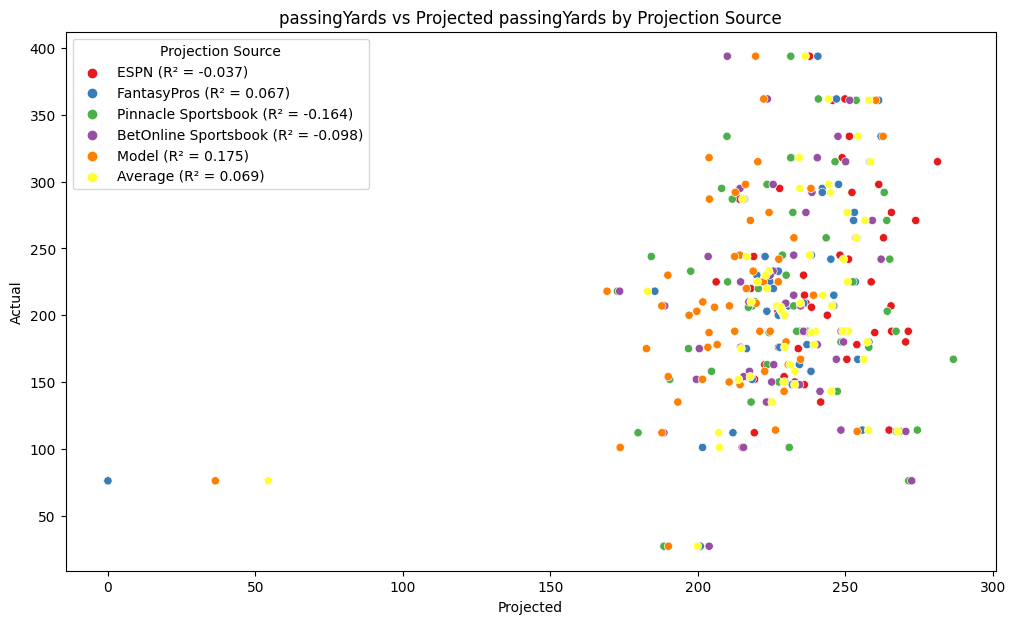

In [628]:
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
def create_ESPN_combo(stat, visualize = True, pos_filter = None):

    # Build Combination Table
    df = LINEUPS
    df['Points'] = df['points']

    ## Filter Where Stat != ESPN & != AVG(ESPN, FP)
    df = df[(df[f'PINNY_{stat}'] != ((df[f'ESPN_{stat}'] + df[f'FP_{stat}'])/2)) & (df[f'BOL_{stat}'] != ((df[f'ESPN_{stat}'] + df[f'FP_{stat}'])/2))]

    ## Filter For Completed Weeks
    df = df[(df['week'] < curr_week) & (~df[f'ESPN_{stat}'].isna())]
    df[f'{stat}'].fillna(0, inplace=True)

    # DF Filter Rows Where Projection is 0 in Pinny
    df = df[df[f'PINNY_{stat}'] > 0]

    if pos_filter is not None:
        df = df[df['primaryPosition'].isin(pos_filter)]

    # Filter any NAs
    df = df.dropna(subset=[f'PINNY_{stat}', f'FP_{stat}'])

    # Build Linear Regression Model
    X = df[[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}']]
    Y = df[f'{stat}']
    model = LinearRegression()
    model.fit(X, Y)
    df[f'COMBO_{stat}'] = model.predict(X)



    # Build Difference Cols
    #df[f"DIFF_ESPN_{stat}"] = df[f"{stat}"] - df[f'ESPN_{stat}']
    #df[f"DIFF_FP_{stat}"] = df[f"{stat}"] - df[f'FP_{stat}']
    #df[f"DIFF_PINNY_{stat}"] = df[f"{stat}"] - df[f'PINNY_{stat}']

    clean = df[['week', 'player_name', f"{stat}", f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'TRUE_{stat}', f'COMBO_{stat}']].sort_values(by=[f"{stat}"], ascending=False)

    if visualize == True:

        label_map = {f"TRUE_{stat}": "Average", f"PINNY_{stat}": "Pinnacle Sportsbook", f"BOL_{stat}": "BetOnline Sportsbook", f"ESPN_{stat}": "ESPN", f"FP_{stat}": "FantasyPros", f"COMBO_{stat}": "Model"}

        df_melted = clean.melt(id_vars=['player_name', f'{stat}'], 
                    value_vars=[f'ESPN_{stat}', f'FP_{stat}', f'PINNY_{stat}', f'BOL_{stat}', f'COMBO_{stat}', f'TRUE_{stat}'],
                    var_name='Projection Source', value_name=f'Projected {stat}')
        
        df_melted.replace({"Projection Source": label_map}, inplace=True)

        r2_scores = {}
        for source in df_melted['Projection Source'].unique():
            subset = df_melted[df_melted['Projection Source'] == source]
            r2 = r2_score(subset[f'{stat}'], subset[f'Projected {stat}'])
            r2_scores[source] = r2


        # Plot using seaborn
        plt.figure(figsize=(12, 7))
        sns.scatterplot(x=f'Projected {stat}', y=f'{stat}', hue='Projection Source', data=df_melted, palette='Set1')


        handles, labels = plt.gca().get_legend_handles_labels()
        new_labels = [f'{label} (R² = {r2_scores[label]:.3f})' for label in labels]
        plt.legend(handles, new_labels, title='Projection Source')

        plt.title(f'{stat} vs Projected {stat} by Projection Source')
        plt.xlabel('Projected')
        plt.ylabel('Actual')
        plt.show()

    elif visualize == False:
        return clean

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

create_ESPN_combo(stat = "passingYards", pos_filter=['QB'], visualize=True) #

In [629]:
def check_week(lu, week, own):

    lu['trueDiff'] = lu['TRUE_Points'] - lu['projPoints']

    # Get My Team
    df = lu[(lu['week'] == week) & (lu['team_owner'] == own)][['week', 'team_name', 'player_name', 'slotPosition', 'primaryPosition',
                                                               'points', 'projPoints', 'FP_Points', 'PINNY_Points', 'BOL_Points', 'TRUE_Points', 'trueDiff',
                                                               'PosRank', 'ESPN_PosRank', 'FP_PosRank', 'PINNY_PosRank', 'BOL_PosRank', 'TRUE_PosRank']]
    
    df = df.rename(columns={
        'team_name': 'team',
        'player_name': 'player',
        'slotPosition': 'rosPos',
        'primaryPosition': 'primPos',
        'points': 'Actual_PTS',
        'projPoints': 'ESPN_PTS',
        'FP_Points': 'FP_PTS',
        'PINNY_Points': 'PINNY_PTS',
        'BOL_Points': 'BOL_PTS',
        'TRUE_Points': 'TRUE_PTS',
        'trueDiff': 'DIFF_PTS',
        'PosRank': 'Actual',
        'ESPN_PosRank': 'ESPN',
        'FP_PosRank': 'FP',
        'PINNY_PosRank': 'PINNY',
        'BOL_PosRank': 'BOL',
        'TRUE_PosRank': 'TRUE',
    })

    # Order
    bench = pd.DataFrame([{
        'week': week,
        'team': df['team'].iloc[0],
        'player': 'Total',
        'rosPos': 'Starting Lineup',
        'primPos': '',
        'Actual_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['Actual_PTS'].sum(),
        'ESPN_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['ESPN_PTS'].sum(),
        'FP_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['FP_PTS'].sum(),
        'PINNY_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['PINNY_PTS'].sum(),
        'BOL_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['BOL_PTS'].sum(),
        'TRUE_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['TRUE_PTS'].sum(),
        'DIFF_PTS': df[~df['rosPos'].isin(['BE', 'IR'])]['DIFF_PTS'].sum(),
        'Actual': '',
        'ESPN': '',
        'FP': '',
        'PINNY': '',
        'BOL': '',
        'TRUE': ''
        
    },
    {
        'week': week,
        'team': df['team'].iloc[0],
        'player': 'Total',
        'rosPos': 'Bench',
        'primPos': '',
        'Actual_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['Actual_PTS'].sum(),
        'ESPN_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['ESPN_PTS'].sum(),
        'FP_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['FP_PTS'].sum(),
        'PINNY_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['PINNY_PTS'].sum(),
        'BOL_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['BOL_PTS'].sum(),
        'TRUE_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['TRUE_PTS'].sum(),
        'DIFF_PTS': df[df['rosPos'].isin(['BE', 'IR'])]['DIFF_PTS'].sum(),
        'Actual': '',
        'ESPN': '',
        'FP': '',
        'PINNY': '',
        'BOL': '',
        'TRUE': ''
        
    }])

    # Append the summary row to the DataFrame
    df = pd.concat([df, bench], ignore_index=True)

    pos_order = ['QB', 'RB', 'WR', 'TE', 'RB/WR/TE', 'OP', 'DP', 'D/ST', 'K', 'Starting Lineup', 'BE', 'Bench', 'IR']
    order_mapping = {val: idx for idx, val in enumerate(pos_order)}
    df = df.sort_values(by=['rosPos', 'TRUE_PTS'], key=lambda x: x.map(order_mapping))

    # Round
    df = df.round(decimals={'FP_PTS': 2, 'PINNY_PTS': 2, 'BOL_PTS': 2, 'TRUE_PTS': 2, 'DIFF_PTS': 3})

    # Drop Actual if Current Week
    if week == curr_week:
        df.drop(['Actual_PTS', 'Actual'], axis=1, inplace=True)

    return df

check_week(lu = LINEUPS, week = curr_week, own='Tommy Winfield')

,week,team,player,rosPos,primPos,ESPN_PTS,FP_PTS,PINNY_PTS,BOL_PTS,TRUE_PTS,DIFF_PTS,ESPN,FP,PINNY,BOL,TRUE
7,3,Steel Your Face,Trevor Lawrence,QB,QB,22.17,22.08,18.90,20.26,20.14,-2.029,15.0,17.0,20.0,15.0,18.0
1,3,Steel Your Face,De'Von Achane,RB,RB,20.65,21.21,20.50,22.31,21.20,0.545,5.0,3.0,3.0,3.0,3.0
0,3,Steel Your Face,Jameson Williams,WR,WR,13.00,12.15,12.57,11.27,12.20,-0.795,29.0,38.0,30.0,41.0,36.0
3,3,Steel Your Face,Rome Odunze,WR,WR,15.43,15.03,14.94,14.82,15.03,-0.395,14.0,12.0,12.0,15.0,12.0
6,3,Steel Your Face,Jake Ferguson,TE,TE,11.49,11.49,9.85,10.15,10.75,-0.745,5.0,5.0,8.0,8.0,8.0
2,3,Steel Your Face,Christian McCaffrey,RB/WR/TE,RB,22.76,23.65,23.21,24.59,23.60,0.837,2.0,1.0,1.0,1.0,1.0
14,3,Steel Your Face,Azeez Al-Shaair,DP,LB,15.88,15.88,15.88,15.88,15.88,0.000,23.0,23.0,23.0,23.0,23.0
11,3,Steel Your Face,Bills D/ST,D/ST,D/ST,22.62,22.45,22.53,22.53,22.53,-0.094,7.0,8.0,8.0,8.0,8.0
8,3,Steel Your Face,Chris Boswell,K,K,13.99,13.99,13.99,13.99,13.99,0.000,6.0,6.0,6.0,6.0,6.0
16,3,Steel Your Face,Total,Starting Lineup,,157.99,157.93,152.37,155.81,155.31,-2.676,,,,,


In [630]:
def get_league_projections(week, lu=LINEUPS):
    df = lu[(lu['week'] == week) & (lu['team_owner'] != 'Free Agent') & (~lu['slotPosition'].isin(['BE', 'IR']))][['week', 'team_owner', 'team_name',
             'points', 'projPoints', 'TRUE_Points']]
    
    df['TRUE_Points'] = df['TRUE_Points'].fillna(df['projPoints'])

    result = df.groupby(['week', 'team_owner', 'team_name'], as_index=False).agg({
        'points': 'sum',
        'projPoints': 'sum',
        'TRUE_Points': 'sum'
        })
    
    result['point_diff'] = result['TRUE_Points'] - result['projPoints']

    return result.sort_values(by='TRUE_Points', ascending=False)

get_league_projections(week = curr_week)

,week,team_owner,team_name,points,projPoints,TRUE_Points,point_diff
6,3,Reece Marsden,Uncle RICO,0.0,163.05,159.522956,-3.527044
11,3,Steven Buckingham,Florida Man,0.0,157.33,157.599926,0.269926
3,3,Jeremy Hughes,Kentucky Redskins,0.0,161.33,157.438203,-3.891797
12,3,Tommy Winfield,Steel Your Face,0.0,157.99,155.313731,-2.676269
4,3,Jon Black,LIES AND COLLUSION,0.0,160.72,153.887047,-6.832953
9,3,Ryan Bonifay,Casa Blumpkin,0.0,154.97,150.928721,-4.041279
5,3,Justin Kemp,P u k a PAC,0.0,149.34,150.471504,1.131504
8,3,Rob Secaur,Mass Laportations,0.0,149.39,147.705443,-1.684557
14,3,Will Sexauer,Touchdown Teddy,0.0,147.94,147.371526,-0.568474
2,3,Chet Martin,Stacey's Gap Blitz,0.0,145.30,144.768150,-0.531850


In [631]:
def get_rankings(pos, week, visualize = False, check_fa = False):
    df = LINEUPS[(LINEUPS['primaryPosition'].isin(pos)) & (LINEUPS['week'] == week)]
    df = df[['week', 'primaryPosition','player_name', 'team_owner', 'team_name',
                  'points', 'projPoints', 'TRUE_Points', 'BOL_Points', 'PosRank', 'ESPN_PosRank', 'TRUE_PosRank']]
    if week != curr_week:
        df = df.sort_values(by=['PosRank', 'points'])
    else:
        df = df.drop(columns=['points', 'PosRank']).sort_values(by=['TRUE_Points'], ascending=False)

    if visualize == False:
        if check_fa == True:
            return df[df['team_owner'].isin(['Tommy Winfield', 'John Baizer', 'Free Agent'])]
        else:
            return df
        
get_rankings(pos = ['WR'], week = curr_week, visualize=False, check_fa=True).head(10) #'LB', 'DE', 'S', 'CB', 'DT'


,week,primaryPosition,player_name,team_owner,team_name,projPoints,TRUE_Points,BOL_Points,ESPN_PosRank,TRUE_PosRank
718,3,WR,Rome Odunze,Tommy Winfield,Steel Your Face,15.43,15.034873,14.822645,14.0,12.0
719,3,WR,Xavier Worthy,Tommy Winfield,Steel Your Face,12.61,12.467683,13.472073,37.0,34.0
715,3,WR,Jameson Williams,Tommy Winfield,Steel Your Face,13.00,12.204704,11.265782,29.0,36.0
720,3,WR,Ricky Pearsall,Tommy Winfield,Steel Your Face,11.38,11.392081,11.390983,41.0,42.0
796,3,WR,Rashod Bateman,Free Agent,Free Agent,9.52,9.334872,9.827593,52.0,55.0
808,3,WR,Dontayvion Wicks,Free Agent,Free Agent,8.51,8.570267,8.838044,58.0,61.0
797,3,WR,Kayshon Boutte,Free Agent,Free Agent,8.48,8.323035,8.438594,59.0,62.0
802,3,WR,Hunter Renfrow,Free Agent,Free Agent,7.69,7.782921,8.038914,62.0,64.0
816,3,WR,Tre Tucker,Free Agent,Free Agent,8.02,7.467890,7.832097,61.0,65.0
822,3,WR,Malik Washington,Free Agent,Free Agent,8.12,7.233112,7.330092,60.0,67.0


In [353]:
grouped_means = LINEUPS[(LINEUPS['player_active_status'] == 'active') & (LINEUPS['week'] == 1)].groupby('primaryPosition').agg({
    'points': 'mean',
    'projPoints': 'mean',
    'ESPN_Points': 'mean',
    'TRUE_Points': 'mean'
}).reset_index().sort_values(by = ['points'], ascending=False)

grouped_means

,primaryPosition,points,projPoints,ESPN_Points,TRUE_Points
2,QB,19.219091,17.836364,17.836364,17.408078
5,WR,11.259677,13.167258,13.167258,12.745610
3,RB,10.121818,11.612000,11.612000,10.980963
1,K,9.571429,8.261429,8.261429,8.261429
4,TE,9.540000,10.539000,10.539000,10.305258
0,D/ST,5.857143,6.084286,6.084286,6.252983


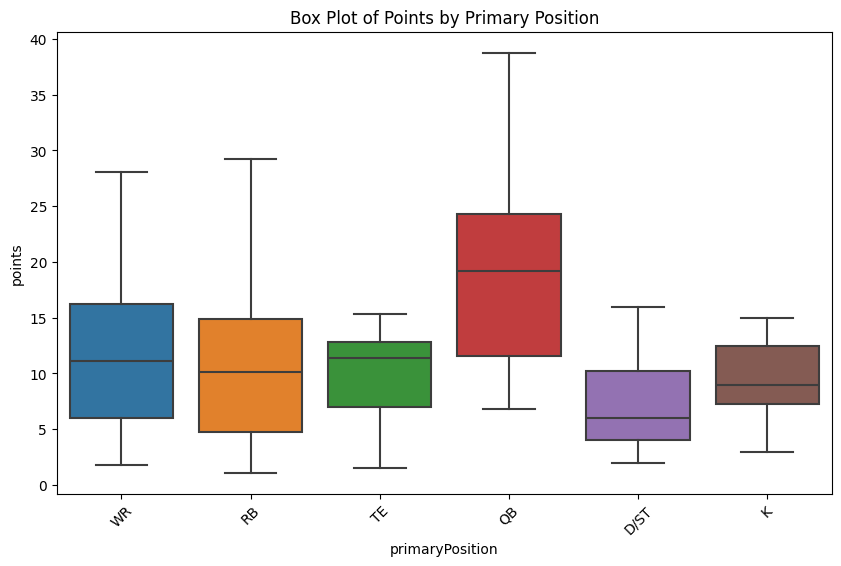

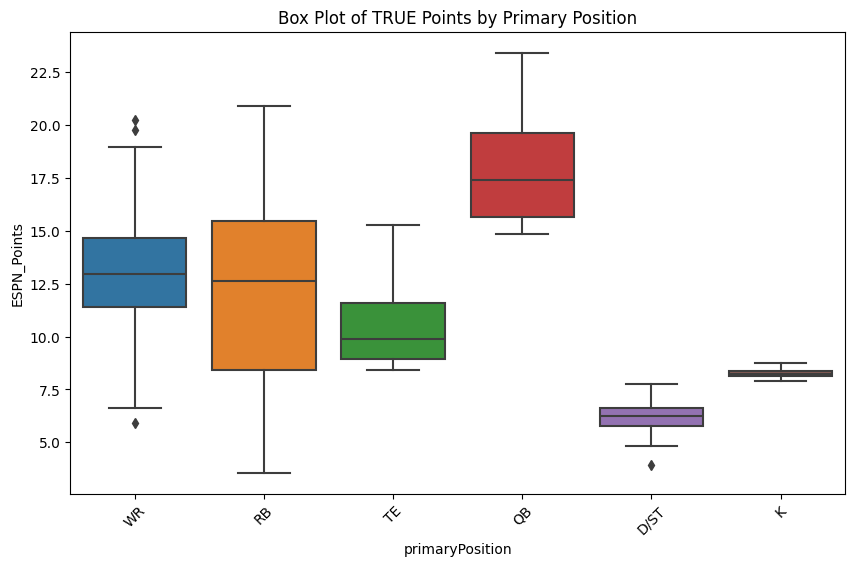

In [354]:
# Box plot for 'points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (~LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['points'] > 1)  & (LINEUPS['week'] < 2)])
plt.title('Box Plot of Points by Primary Position')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

# Box plot for 'TRUE_Points'
plt.figure(figsize=(10, 6))
sns.boxplot(x='primaryPosition', y='ESPN_Points', data=LINEUPS[(LINEUPS['player_active_status'] == 'active') & (~LINEUPS['primaryPosition'].isin(['DE', 'DT', 'CB', 'S', 'LB'])) & (LINEUPS['points'] > 1) & (LINEUPS['week'] < 2)])
plt.title('Box Plot of TRUE Points by Primary Position')
plt.xticks(rotation=45)
plt.show()

   primaryPosition             player_name  points  projPoints  TRUE_Points  \
40              RB     Christian McCaffrey     0.0       20.82    21.674978   
39              RB  Jacory Croskey-Merritt     0.0       11.29    12.110310   
38              RB              Nick Chubb     0.0       11.92    12.711821   
37              RB            J.K. Dobbins     0.0       11.77    12.552504   
36              RB            Jordan Mason     0.0       14.67    15.234625   
35              RB          Saquon Barkley     0.0       18.62    19.136615   
34              RB         Omarion Hampton     0.0       12.21    12.637424   
33              RB        Quinshon Judkins     0.0        9.00     9.422895   
32              RB      Travis Etienne Jr.     0.0       12.73    13.138712   
31              RB            James Conner     0.0       13.43    13.832961   

    projDiff  
40  0.854978  
39  0.820310  
38  0.791821  
37  0.782504  
36  0.564625  
35  0.516615  
34  0.427424  
33  0.4228

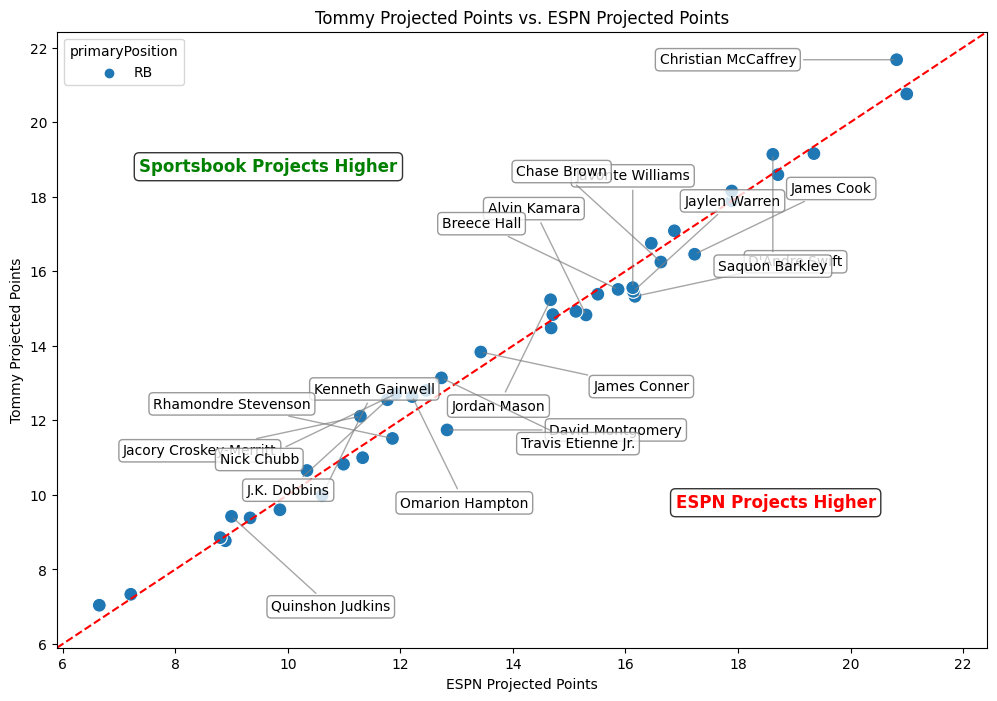

In [367]:
def plot_proj(df = LINEUPS, week=curr_week, pos = ['QB', 'RB', 'WR', 'TE']):

    # Filter by Position
    df = df[df['primaryPosition'].isin(pos)]

    # Filter For only Players You'd. consider playing
    df = df[df['TRUE_Points'] > 7]

    df['projDiff'] = df['TRUE_Points'] - df['projPoints']

    df = df[(df['projPoints'] > 0) & (df['week'] == week)].groupby(['primaryPosition', 'player_name'])[['points', 'projPoints', 'TRUE_Points', 'projDiff']].mean().sort_values(['projDiff'], ascending=True)
    df = df.reset_index()

    # Get the top 10 highest and 10 lowest values of projDiff
    top_10_projDiff = df[~df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT'])].nlargest(10, 'projDiff')
    bottom_10_projDiff = df[~df['primaryPosition'].isin(['CB', 'S', 'LB', 'DE', 'DT'])].nsmallest(10, 'projDiff')

    # Combine the top and bottom values into one DataFrame
    top_bottom_projDiff = pd.concat([bottom_10_projDiff, top_10_projDiff])

    print(top_10_projDiff)
    print(bottom_10_projDiff)


    plt.figure(figsize=(12, 8))

    scatter_plot = sns.scatterplot(
        y='TRUE_Points', 
        x='projPoints', 
        hue='primaryPosition',  # Color by primaryPosition
        data=df, 
        s=100  # Adjust point size if needed
    )

    for line in range(0, top_bottom_projDiff.shape[0]):
        x_point = top_bottom_projDiff.projPoints.iloc[line]
        y_point = top_bottom_projDiff.TRUE_Points.iloc[line]

        # Create different offsets for different positions to avoid overlap
        # You can adjust these multipliers to spread labels further
        angle = np.pi * line / len(top_bottom_projDiff) * 2  # Distribute around circle
        x_offset = 3 * np.cos(angle)  # Larger offset
        y_offset = 3 * np.sin(angle)

        scatter_plot.annotate(
            top_bottom_projDiff.player_name.iloc[line],
            xy=(x_point, y_point),  # Point location
            xytext=(x_point + x_offset, y_point + y_offset),  # Text location
            fontsize=10,
            color='black',
            ha='center',
            va='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='gray'),
            arrowprops=dict(arrowstyle='-', color='gray', lw=1, alpha=0.7)
        )

    # Add a line with slope=1 and intercept=0 (line of equality)
    #max_val = max(df['TRUE_Points'].max(), df['projPoints'].max())  # Find the maximum value for the plot limit

    # Find the overall min and max across both variables
    overall_min = min(df['projPoints'].min(), df['TRUE_Points'].min())
    overall_max = max(df['projPoints'].max(), df['TRUE_Points'].max())

    # Add padding
    padding = (overall_max - overall_min) * 0.05

    # Set equal limits for both axes
    plt.xlim(overall_min - padding, overall_max + padding)
    plt.ylim(overall_min - padding, overall_max + padding)

    # Also update your diagonal line
    plt.plot([overall_min - padding, overall_max + padding], 
             [overall_min - padding, overall_max + padding], 
             color='red', linestyle='--', label='y = x')
    
    # Calculate position for labels (roughly 1/4 and 3/4 along the diagonal)
    mid_point = (overall_min + overall_max) / 2
    label_offset = (overall_max - overall_min) * 0.30
    
    # "ESPN Projects Higher" label (below diagonal line, in red)
    plt.text(mid_point + label_offset, mid_point - label_offset, 
             'ESPN Projects Higher', 
             fontsize=12, 
             color='red', 
             fontweight='bold',
             ha='center',
             rotation=0,  # Rotate to match the diagonal
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    # "Sportsbook Projects Higher" label (above diagonal line, in blue or green)
    plt.text(mid_point - label_offset, mid_point + label_offset, 
             'Sportsbook Projects Higher', 
             fontsize=12, 
             color='green',  # or 'green' if you prefer
             fontweight='bold',
             ha='center',
             rotation=0,  # Rotate to match the diagonal
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

    # Set plot title and labels
    plt.title('Tommy Projected Points vs. ESPN Projected Points')
    plt.ylabel('Tommy Projected Points')
    plt.xlabel('ESPN Projected Points')

    # Show the plot
    plt.show()

plot_proj(LINEUPS, curr_week, pos = ['RB'])

### Simulation Sandbox

In [368]:
sim = django_simulation(league=league, n_simulations=500)

# Convert each list to a DataFrame
df_general = pd.DataFrame(sim[0])
df_position_odds = pd.DataFrame(sim[1])
df_standings = pd.DataFrame(sim[2])

# Merge DataFrames on 'team' and 'owner' columns (assuming they are common keys)
df_merged = df_general.merge(df_position_odds, on=['team', 'owner'], suffixes=('_general', '_odds'))
df_final = df_merged.merge(df_standings, on=['team', 'owner'], suffixes=('', '_standings'))

print(df_final.sort_values(by=['projected_wins'], ascending=[False]))

playoff_odds_swing(league = league, week = 2)

# Power Rankings
print(pd.DataFrame(django_power_rankings(league=league, week=1)))

Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 422 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    3.6s finished


                      team              owner  projected_wins  \
0         Senorita Awesome     Tommy Winfield            13.1   
1             PetroDragons    Bryan Stieneker            10.8   
2             Tony P's Hog     Turner Banwell            10.7   
3     She De On my Sanders  Charlie Voudouris            10.5   
9          Kyle Pitts Year      Walker Thomas             8.8   
5                   Room40    Thomas Freeland             6.4   
4   Atlanta Dream Superfan         Sam Boxley             6.2   
6                Team Ryan       Patrick Ryan             5.5   
10           The Fireballz           Corson P             5.0   
11           Team Crenshaw    Miller Crenshaw             4.7   
13  Skrilla Aura King Dart     Robert Cooleen             4.7   
7       Waddle These Knuts      Peter Knutson             4.4   
8       Tacos y enchiladas       Andrew Blair             4.4   
12   Cantrell Underdog Men      Alex Cantrell             2.8   

    projected_losses  pr

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  73 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  73 out of 100 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Simulating from week 3 to 14


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


                      team  value              owner
0             PetroDragons  21.75    Bryan Stieneker
1         Senorita Awesome  20.95     Tommy Winfield
2   Atlanta Dream Superfan  20.00         Sam Boxley
3     She De On my Sanders  18.60  Charlie Voudouris
4          Kyle Pitts Year  17.95      Walker Thomas
5             Tony P's Hog  17.65     Turner Banwell
6   Skrilla Aura King Dart  17.15     Robert Cooleen
7            Team Crenshaw  16.25    Miller Crenshaw
8       Tacos y enchiladas  15.60       Andrew Blair
9       Waddle These Knuts  14.55      Peter Knutson
10           The Fireballz  14.30           Corson P
11   Cantrell Underdog Men  13.40      Alex Cantrell
12                  Room40  11.70    Thomas Freeland
13               Team Ryan  10.75       Patrick Ryan


### Historical Stats

- **Efficiency**
    - The rate at which a team starts an optimal lineup

In [319]:
league_history = scrape_team_stats(league_id=lg_vars[select_league]['ID'],
        start_year=2022,
        end_year=lg_vars[select_league]['end'],
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2'])

league_history = league_history[(league_history['year'] <= 2024) | ((league_history['year'] == 2025) & (league_history['week'] <= curr_week))]

weekly_stats_analysis(df=league_history, year=2025, week=curr_week - 1)
print(" ")
season_stats_analysis(league=league, df=league_history, week=curr_week - 1)
print(" ")
all_time_stats_analysis(league=league, df=league_history)


[BUILDING LEAGUE] Fetching historical stats for 2022...
BUILDING 2022 Season For Knights FFL  

[BUILDING LEAGUE] Fetching historical stats for 2023...
BUILDING 2023 Season For Knights FFL  

[BUILDING LEAGUE] Fetching historical stats for 2024...
BUILDING 2024 Season For Knights FFL  

[BUILDING LEAGUE] Fetching historical stats for 2025...
BUILDING 2025 Season For Knights FFL  
----------------------------------------------------------------
|                        Week  2 Analysis                      |
----------------------------------------------------------------
League-wide POSITIVE stats
--------------------------
Peter Knutson had the 3rd highest K_pts (23.00 pts) in league history


Franchise POSITIVE stats
--------------------------
Tommy Winfield had the 3rd highest team_score (150.10 pts) in franchise history
Thomas Freeland had the 2nd highest team_score_adj (141.96 pts) in franchise history
Tommy Winfield had the 1st highest team_score_adj (172.76 pts) in franchise hi

In [369]:
h2h_build(df = league_history, owner1 = 'Tommy Winfield', owner2='Corson P')

,,games,wins,losses,ties,PF,PA,margin,win_pct
team_owner,opp_owner,,,,,,,,
Tommy Winfield,Corson P,3,1,2,0,94.793333,98.273333,-3.48,0.333333


In [ ]:
years = range_values = list(range(2024, 2025))
weeks = range_values = list(range(1, 17))
lab = f"{select_league} - Historical Stats From {years[0]} to {years[-1]}"

team_stats_list = []
for y in years:
    league = fetch_league(
        league_id=lg_vars[select_league]['ID'],
        year=y,
        swid=lg_vars[select_league]['SWID'],
        espn_s2=lg_vars[select_league]['ESPN_S2']
    )
    for week in weeks:
        for i in league.teams:
            # Init DF
            team_stats = {}

            # Teams
            team_lineup = get_lineup(league, i, week=week)
            opp_lineup = get_opp_lineup(league, i, week=week)

            # League Information
            team_stats['leagueName'] = league.name

            # Time
            team_stats['year'] = y
            team_stats['week'] = week

            # Team Information
            team_stats['teamID'] = i.team_id
            team_stats['teamOwner'] = i.owner


            # Efficiency Stats
            team_stats['trueScore'] = np.sum([player.points for player in team_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['bestScore'] = get_best_lineup(league, team_lineup)
            team_stats['efficiencyScore'] = get_lineup_efficiency(league, team_lineup)
            team_stats['projAdherance'] = get_idiot_score(league, team_lineup)
            team_stats['scoreDifference'] = get_score_surprise(league, team_lineup)

            # OppStats
            team_stats['opp_trueScore'] = np.sum([player.points for player in opp_lineup if player.slot_position not in ("BE", "IR")])
            team_stats['opp_bestScore'] = get_best_lineup(league, opp_lineup)
            team_stats['opp_efficiencyScore'] = get_lineup_efficiency(league, opp_lineup)
            team_stats['opp_projAdherance'] = get_idiot_score(league, opp_lineup)
            team_stats['opp_scoreDifference'] = get_score_surprise(league, opp_lineup)

            # Differences
            team_stats['margin'] = team_stats['trueScore'] - team_stats['opp_trueScore']
            team_stats["optimalMargin"] = team_stats['bestScore'] - team_stats['opp_bestScore']
            team_stats["efficiencyMargin"] = team_stats['efficiencyScore'] - team_stats['opp_efficiencyScore']
            team_stats["scoreDifferenceMargin"] = team_stats['scoreDifference'] - team_stats['opp_scoreDifference']

            # Outcomes
            team_stats['isWin'] = np.where(team_stats['margin'] > 0, 1, 0)
            team_stats['isTie'] = np.where(team_stats['margin'] == 0, 1, 0)
            team_stats['isLoss'] = np.where(team_stats['margin'] < 0, 1, 0)
            team_stats['isOptimalWin'] = np.where(team_stats['optimalMargin'] > 0, 1, 0)
            team_stats['isOptimalTie'] = np.where(team_stats['optimalMargin'] == 0, 1, 0)
            team_stats['isOptimalLoss'] = np.where(team_stats['optimalMargin'] < 0, 1, 0)
            team_stats['netWinsAdded'] = np.where((team_stats['isWin'] == 1) & (team_stats['isOptimalWin'] == 0), 1, 0)
            team_stats['netLossAdded'] = np.where((team_stats['isLoss'] == 1) & (team_stats['isOptimalWin'] == 1), 1, 0)
            team_stats['netLuck'] = team_stats['netWinsAdded'] - team_stats['netLossAdded']

            # Luck
            try:
                team_stats['luckIndex'] = get_weekly_luck_index(league=league, team = i, week=week)
            except:
                team_stats['luckIndex'] = 0

            # Append
            if y < 2024 or (y == 2024 and week < 3):
                team_stats_list.append(team_stats)
                
team_stats_df = pd.DataFrame(team_stats_list)


In [ ]:
# Group By # , 'year'
hist_stats_df = team_stats_df.groupby(['leagueName', 'week', 'teamID', 'teamOwner']).agg(
    Efficency = ('efficiencyScore', 'mean'),
    W=("isWin", "sum"),
    L=("isLoss", "sum"),
    T=("isTie", "sum"),
    xW=("isOptimalWin", "sum"),
    xL=("isOptimalLoss", "sum"),
    xT=("isOptimalTie", "sum"),
    Luck_W=("netLuck", "sum"),
    TruePF=('trueScore', 'mean'),
    OptimalPF=('bestScore', 'mean'),
    TruePA=('opp_trueScore', 'mean'),
    OptimalPA=('opp_bestScore', 'mean'),
    AdhereProj = ('projAdherance', 'mean'),
    TrueMargin = ('margin', 'mean'),
    #OptimalMargin = ('optimalMargin', 'mean'),
    #PF_OnTable = ('scoreDifference', 'mean'),
    Luck_Index = ('luckIndex', 'mean')
    ).reset_index()\
     .sort_values(by=['Luck_Index'], ascending=False)

print(lab)
hist_stats_df

In [ ]:
# Mapping
years = hist_stats_df['year'].sort_values(ascending=False).unique()
cmap = plt.get_cmap('tab10')
color_dict = {year: cmap(i) for i, year in enumerate(years)}

# Plotting
plt.figure(figsize=(12, 8))

plt.scatter(
    hist_stats_df['AdhereProj'],
    hist_stats_df['Efficency'],
    c=hist_stats_df['year'].map(color_dict),
    label='Data Points')

# Adding labels
texts = []
for i in range(len(hist_stats_df)):
    owner_year = f"{hist_stats_df['teamOwner'][i]}"
    texts.append(plt.text(hist_stats_df['AdhereProj'][i], hist_stats_df['Efficency'][i],
                          owner_year, fontsize=9, ha='center'))
    
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='red', lw=0.5))

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[year], markersize=10) 
           for year in years]
plt.legend(handles, years, title="Year")
    

plt.xlabel('Adherance To ESPN Projections')
plt.ylabel('Correct Start Rate')
plt.title('Scatter Plot of Adherance To Projections vs. Correct Start Rate')
plt.grid(True)
plt.show()

## Projections

In [ ]:
years = range_values = list(range(2024, 2025))
stats_df = pd.DataFrame()
for y in years:
        ply_stats = get_stats_by_matchup(league_id=lg_vars[select_league]['ID'],
                year=y,
                swid=lg_vars[select_league]['SWID'],
                espn_s2=lg_vars[select_league]['ESPN_S2'])
        
        stats_df = pd.concat([stats_df, ply_stats]).fillna(0)


stats_df.head()

In [ ]:
stats_df['diff'] = stats_df['points'] - stats_df['projPoints']
# Set up plot area
plt.figure(figsize=(12, 8))

# Create a violin plot for each primaryPosition
sns.violinplot(x='slotPosition', y='points', data=stats_df)

# Labels and title
plt.xlabel('Primary Position')
plt.ylabel('Points')
plt.title('Distribution of Points by Primary Position')

# Show plot
plt.show()

In [ ]:
stats_df = stats_df[stats_df['week'] < 3]
grouped_df = stats_df[stats_df['week'] < 3].groupby(['year','week', 'primaryPosition', 'player_name'])

positions = stats_df['primaryPosition'].unique()

# Set up plot area
plt.figure(figsize=(20, 12))

# Loop through each primaryPosition
for pos in positions:
    pos_data = stats_df[stats_df['primaryPosition'] == pos]
    
    # Scatter plot
    plt.scatter(pos_data['points'], pos_data['projPoints'], label=pos)

    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))

    # Display R² value
    plt.text(pos_data['points'].mean(), pos_data['projPoints'].mean(), f"R²: {r2:.2f}", fontsize=9)

# Labels and legend
plt.xlabel('Points')
plt.ylabel('Projected Points')
plt.title('Points vs Projected Points by Primary Position')
plt.legend(title="Primary Position")
plt.show()

In [ ]:
# Get unique positions
positions = stats_df['player_name'].unique()

# Set up multi-plot grid
n_cols = 3
n_rows = (len(positions) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

# Loop through each player_name and create scatter plots
for i, pos in enumerate(positions):
    pos_data = stats_df[stats_df['player_name'] == pos]
    
    # Scatter plot
    sns.scatterplot(x='points', y='projPoints', data=pos_data, ax=axes[i], color='blue')
    
    # Calculate R² using Linear Regression
    X = pos_data['points'].values.reshape(-1, 1)
    y = pos_data['projPoints'].values
    model = LinearRegression().fit(X, y)
    r2 = r2_score(y, model.predict(X))
    
    # Add R² value to the plot
    axes[i].text(0.05, 0.95, f'R²: {r2:.2f}', transform=axes[i].transAxes, fontsize=12, verticalalignment='top')
    
    # Set title and labels
    axes[i].set_title(f"Primary Position: {pos}")
    axes[i].set_xlabel('Points')
    axes[i].set_ylabel('Projected Points')

# Remove empty subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show plot
plt.tight_layout()
plt.show()

### Positional Variance Between Projections and Actual

### Power Rankings

In [ ]:
league.power_rankings(league.current_week)

In [ ]:
get_season_luck_indices(league, week)